## Stanley tracker

Stanley controller was used in the [DARPA-challenge winning autonomous vehicle](http://isl.ecst.csuchico.edu/DOCS/darpa2005/DARPA%202005%20Stanley.pdf), back in the day. 
It is a non-linear controller, which explicitly takes into account **ref_theta** unlike pure pursuit. Because it was used for a car, a bicycle model is to be used for vehicular motion

Trackers are trying to minimize 2 types of errors

1. Positional error or cross-track error $x_e$

2. Heading error $\theta_e$

Tracker controls the steering as a function of these 2 errors

$\delta = \theta_e + \tan^{-1}\frac{kx_e}{v}$

The second term can be thought of as how quickly do we want the vehicle to compensate for the positional error relative to vehicle velocity


Snider has a nice/ concise summary of how it works in Sec 2.3 of his Phd thesis
https://www.ri.cmu.edu/pub_files/2009/2/Automatic_Steering_Methods_for_Autonomous_Automobile_Path_Tracking.pdf

There is a reference implementation here
https://github.com/AtsushiSakai/PythonRobotics/blob/master/PathTracking/stanley_controller/stanley_controller.py

+ Take the smoothened trajectory of straight/ right turn/ straight from week 2. 
+ Induce a small error in initial pose. 
+ Simulate vehicular motion using the Stanley tracker

In [1]:
# Import everything
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Load the path

In [2]:
!tree

.
└── data
    ├── astar_grid.npy
    └── srs_path.npy

1 directory, 2 files


In [3]:
# Load the path
ref_path = np.load("./data/srs_path.npy")
x_ref = ref_path[:, 0]
y_ref = ref_path[:, 1]
th_ref = ref_path[:, 2]

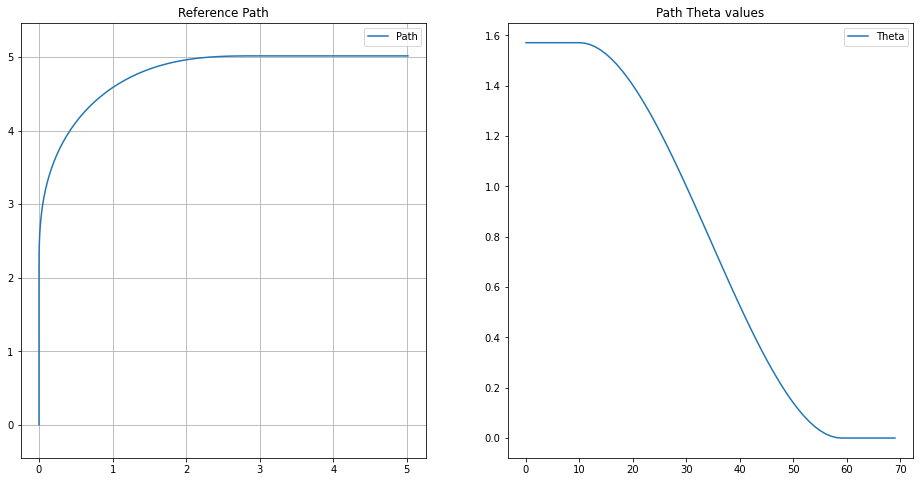

In [4]:
# Show a preview
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.plot(x_ref, y_ref, label="Path")
plt.grid()
plt.axis("equal")
plt.title("Reference Path")
plt.legend()
plt.subplot(1,2,2)
plt.plot(th_ref, label="Theta")
plt.title("Path Theta values")
plt.legend()
plt.show()

In [5]:
L_default = 0.2
dt_default = 0.05
# Define a Bicycle Model
def simulate_bicycle(pose, v, delta, dt=dt_default, L=L_default):
  """
  Simulate a step in the bicycle model
  pose -> (x, y, th in rad)
  v -> Current velocity
  delta -> Steering angle
  dt -> Time step
  L -> Vehicle length
  """
  x, y, t = pose
  x_new = x + v * np.cos(t) * dt
  y_new = y + v * np.sin(t) * dt
  t_new = t + ((v/L) * np.tan(delta) * dt)
  t_new = np.arctan2(np.sin(t_new), np.cos(t_new))  # Limit [-pi, pi]
  return x_new, y_new, t_new

In [6]:
class StanleyTracker:
  def __init__(self, x, y, th, v_target, k, Kp=1.0, L=L_default, max_del=30):
    """
    Tracks the path defined by x, y, th reference arrays
    x, y, th -> numpy arrays (reference)
    v_target -> float-like (target velocity)
    k -> float-like (control gain for correction of front axel error)
    Kp -> float-like (gain for P controller)
    L -> float-like (length of vehicle)
    max_del -> float-like (maximum steering angle, degrees)
    """
    self.length = len(x)
    self.ref_idx = 0  # Index on path to track (start with 0)
    self.x, self.y, self.th = (x, y, th)
    self.v_target = v_target
    self.v, self.delta = (0, 0)
    self.acc = 0  # Starting acceleration is 0 (use this in state updates)
    self.k = k
    self.Kp = Kp
    self.L = L
    self.max_del = np.deg2rad(max_del)
  
  def calc_target_idx(self, xc, yc, thc):
    """
    Calculate the target index and front axel error
    xc, yc, thc -> Current pose of the robot
    """
    # Front axel position (from the structure of unicycle)
    faxp_x = xc + self.L * np.cos(thc)
    faxp_y = yc + self.L * np.sin(thc)
    # Search for the nearest point in the trajectory
    #  dx, dy from all points in trajector to front axel
    #  get distance using Pythagoras theorem and the index
    #  of minimum distance is the target index
    dx_vals = [faxp_x - px for px in self.x]
    dy_vals = [faxp_y - py for py in self.y]
    diag_vals = np.hypot(dx_vals, dy_vals)
    target_idx = np.argmin(diag_vals)
    # Calculate the offset error (front axel)
    #  get two vectors
    #  1. The vector from front axel to the path (add
    #     pi/2 for the radial direction of wheel)
    #  2. The vector [dx[ti], dy[ti]], which is the
    #     shortest vector from path to vehicle
    #  their dot product is the error in path tracking (offset)
    front_axel_vec = [-np.cos(thc+np.pi/2), -np.sin(thc+np.pi/2)]
    err_front_axel = np.dot([dx_vals[target_idx], dy_vals[target_idx]], 
                            front_axel_vec) # Error in that direction
    return target_idx, err_front_axel

  def update(self, xc, yc, thc):
    """
    Update the simulation
    xc, yc, thc -> Current pose of the robot (th in radians)
    Returns "True" if ended, else "False"
    """
    # Calculate acceleration
    #  used by main caller to update v
    #  v will be updated in the end (state change)
    self.acc = self.Kp * (self.v_target - self.v)
    # Main controller code
    #  Current target index and front axel error
    #  compare with the self.length (to check for
    #  ending criteria)
    curr_target_idx, front_axel_err = self.calc_target_idx(xc, yc, thc)
    self.ref_idx = max(self.ref_idx, curr_target_idx) # Tracking index
    if self.ref_idx >= self.length-1: # Tracking ended (last point reached)
      return True
    #  Calculate the theta_e value from reference
    #  and current yaw values (simple heading correction)
    theta_e =  self.th[self.ref_idx] - thc
    theta_e = np.arctan2(np.sin(theta_e), np.cos(theta_e))  # Bounded
    #  Calculate the steering angle needed to
    #  correct the front_axel_error (based on gain, error and velocity)
    #  This is the theta_d, taninv formula (component of delta)
    theta_d = np.arctan2(self.k * front_axel_err, self.v)
    #  The steering angle
    self.delta = np.clip(theta_e + theta_d, -self.max_del, self.max_del)
    # Return, but simulation must continue
    return False

Write the actual simulation code

In [7]:
# Configurations
L_val = 0.2
dt_val = 0.1
v_target = 0.5  # m/s
k_val = 0.7 # Simulation gain for tracking error
# Tracker object
tracker = StanleyTracker(x_ref, y_ref, th_ref, v_target, k_val, Kp=1.0, 
                         L=L_val, max_del=45)
init_pose = (-0.1, -0.2, np.pi + np.deg2rad(60))  # Initial pose of robot
robot_trag = [init_pose]
robot_v_vals = []
robot_delta_vals = []
robot_acc_vals = []
curr_pose = init_pose
# Failsafe criteria
sim_time = 100  # terminate in 100 sec regardless of outcome
ctime = 0.0
dt = dt_val
# Run simulation till end
while ctime <= sim_time:
  # Run the update loop
  if tracker.update(*curr_pose):
    print("ARRIVED!!")
    break
  # Update the pose from the simulation data
  x_new, y_new, th_new = simulate_bicycle(curr_pose, tracker.v, tracker.delta, 
                                          L=L_val, dt=dt_val)
  tracker.v += tracker.acc * dt # Update the velocity in simulation
  curr_pose = (x_new, y_new, th_new)
  ctime += dt
  # Append data for plotting later
  robot_trag.append(curr_pose)
  robot_v_vals.append(tracker.v)
  robot_delta_vals.append(tracker.delta)
  robot_acc_vals.append(tracker.acc)
print(f"Simulation ended in {ctime:.2f} seconds")

ARRIVED!!
Simulation ended in 19.90 seconds


In [8]:
# Convert everything being tracked throughout simulation to numpy arrays
np_robot_trag = np.array(robot_trag)
np_robot_v_vals = np.array(robot_v_vals)
np_robot_delta_vals = np.array(robot_delta_vals)
np_robot_acc_vals = np.array(robot_acc_vals)

Visualize everything

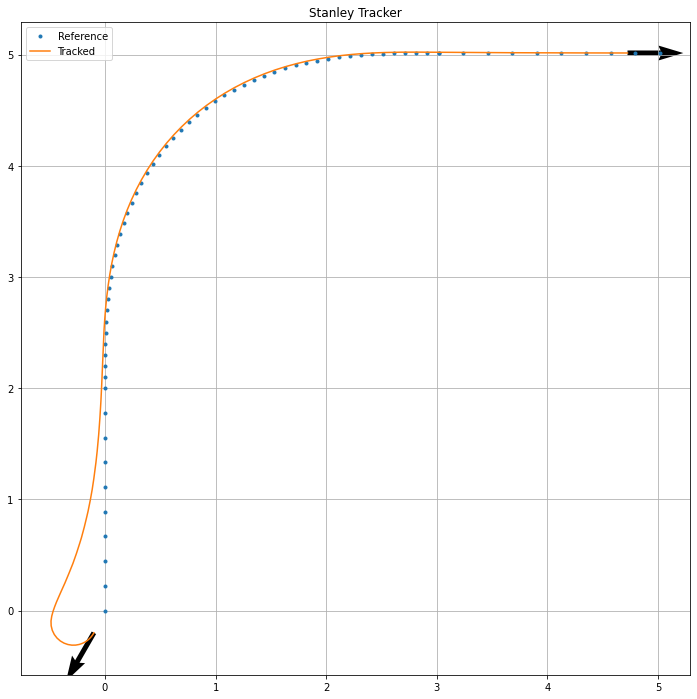

In [9]:
# Robot path
plt.figure(figsize=(12,12))
plt.plot(x_ref, y_ref, '.',label="Reference")
plt.plot(np_robot_trag[:, 0], np_robot_trag[:, 1], label="Tracked")
# Quiver (start and end)
plt.quiver(init_pose[0], init_pose[1], 
        np.cos(init_pose[2]), np.sin(init_pose[2]), scale=12)
plt.quiver(np_robot_trag[-1, 0], np_robot_trag[-1, 1],
        np.cos(np_robot_trag[-1, 2]), np.sin(np_robot_trag[-1, 2]), scale=12)
plt.title('Stanley Tracker')
plt.legend()
plt.grid()
plt.show()

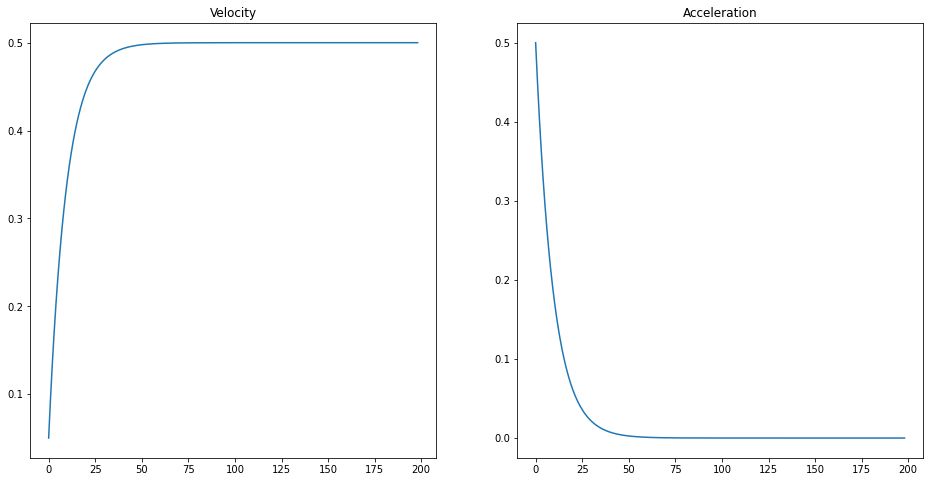

In [10]:
# Robot velocity and delta
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.title("Velocity")
plt.plot(np_robot_v_vals)
plt.subplot(1,2,2)
plt.title("Acceleration")
plt.plot(np_robot_acc_vals)